# Introduction Raster data

In [21]:
%matplotlib inline

import numpy as np
import rasterio
from rasterio.plot import show

The two primary types of geospatial data are raster and vector data. Vector data structures represent specific features on the Earth’s surface, and assign attributes to those features. 

__Raster data__ is stored as a grid of values which are rendered on a map as pixels. Raster files are different from photographs in that they are spatially referenced. Each pixel represents an area of land on the ground. That area is defined by the spatial resolution of the raster.

![](../img/raster-concept.png)
<small>_Source: Colin Williams, NEON._</small>

## Importing raster data

Similar to geospatial feature based data, rastyer data is often available from specific GIS file formats or data stores, like Geotiff files, Esri grid, NetCDF files, PostGIS (PostgreSQL) database, ...

We can use the [Rasterio library](https://rasterio.readthedocs.io/en/latest/) to read many of those GIS file formats, using the `rasterio.open` function.

Let's start by reading and plotting a Geotiff file (the file is available in the `./data/herstappe/raster` directory):

In [121]:
ndvi_herstappe = "./data/herstappe/raster/2018-09-18_Sentinel_2_L2A_NDVI.tiff"

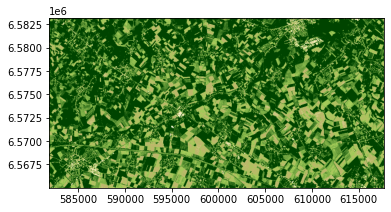

In [253]:
with rasterio.open(ndvi_herstappe) as src:
    herstappe_ndvi = src.read()
    show(herstappe_ndvi, transform=src.transform)

A raster is just an __image__ in local pixel coordinates until we specify what part of the earth the image covers. This is done through the usage of raster file metadata. It depends on the file type how these are stored on disk. When reading in a file, the metadata need to be interpreted as well in order to know the __spatial information__.

## Raster data attributes

To quickly scan the spatial metadata of a Raster data file, let's use the [`gdalinfo` command](https://gdal.org/programs/gdalinfo.html#gdalinfo). 

> The `gdalinfo` command lists information about a raster dataset.

It is not a Python command, but a program that need to be run from the terminal (aka command line). Using a small Jupyter notebook - `!` trick, we can use it within the notebook as well: 

In [127]:
!gdalinfo ./data/herstappe/raster/2018-09-18_Sentinel_2_L2A_NDVI.tiff

Driver: GTiff/GeoTIFF
Files: ./data/herstappe/raster/2018-09-18_Sentinel_2_L2A_NDVI.tiff
Size is 625, 317
ERROR 1: PROJ: proj_create_from_database: datum not found
ERROR 1: PROJ: proj_create_from_database: ellipsoid not found
proj_create_from_database: datum not found
proj_create_from_database: ellipsoid not found
Coordinate System is:
PROJCRS["WGS 84 / Pseudo-Mercator",
    BASEGEOGCRS["WGS 84",
        DATUM["World Geodetic System 1984",
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326]],
    CONVERSION["Popular Visualisation Pseudo-Mercator",
        METHOD["Popular Visualisation Pseudo Mercator",
            ID["EPSG",1024]],
        PARAMETER["Latitude of natural origin",0,
            ANGLEUNIT["degree",0.0174532925199433],
            ID["EPSG",8801]],
        PARAMETER["Longitude of natural origin",0,
            ANGLEUNIT["degr

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

The [`gdal` library](https://gdal.org/) is a very powerful set of functions. It is the
open source Swiss Army knife for raster and vector geospatial data handling. GDAL provides Python bindings to run it from Python code, but these are not very 'Pythonic'. When familiar with the command line the [command line raster functions](https://gdal.org/programs/index.html#raster-programs) (CLI) are certainly worthwhile to check out!
    
You can run a CLI command inside a Jupyter Notebook by prefixing it with the `!` character.

</div>

Important information we get from the `gdalinfo` command are 

* Coordinate reference system (CRS), see also [02-coordinate-reference-systems notebook](./02-coordinate-reference-systems.ipynb).
* Number of bands in the data set: A data set can contain one (single) or more (multi) layers (bands).
* Spatial resolution: This resolution represents the area on the ground that each pixel covers. The units for your data are determined by the CRS above (e.g. meters).
* Spatial extent (bounding box) of the data: The geographic area that the raster data covers.

<img src="../img/raster-spatial-extent-coordinates.png" alt="spatial-extnet" style="width:500px;"/>

<small>_Image Source: National Ecological Observatory Network (NEON)._</small>

Let's see how Rasterio interprets this information: 

In [213]:
src = rasterio.open(ndvi_herstappe)

In [214]:
src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 625,
 'height': 317,
 'count': 3,
 'crs': CRS.from_epsg(3857),
 'transform': Affine(57.32777121388223, 0.0, 581895.9870779756,
        0.0, -57.44833434998037, 6583215.49808909)}

The `meta` attribute contains some of the essential information. Some of these are also stored in a separate attribute:

In [199]:
src.crs, src.count

(CRS.from_epsg(3857), 3)

In [200]:
src.crs == src.meta["crs"]

True

The `meta` attribute misses information on the spatial resolution and spatial extent, available in separate attributes:

In [203]:
src.res

(57.32777121388223, 57.44833434998037)

In [204]:
src.bounds

BoundingBox(left=581895.9870779756, bottom=6565004.376100146, right=617725.844086652, top=6583215.49808909)

Geotiff files can also contain a data mask to define which pixels contain valid data and which are no data. Raster data often has such a `NoDataValue`. To extract the mask, use the `dataset_mask` method, which returns 255 for valid data and 0 for nodata:

In [219]:
src.dataset_mask()

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

We should not forget to close the file afterwards!

In [220]:
src.close()

## Using context manager to open files

A better approach instead of opening and closing the data file separately is to use a Python [context manager](https://docs.python.org/3/reference/compound_stmts.html#with):

In [206]:
with rasterio.open(ndvi_herstappe) as src:
    print(src)

<open DatasetReader name='./data/herstappe/raster/2018-09-18_Sentinel_2_L2A_NDVI.tiff' mode='r'>


In [207]:
print(src)

<closed DatasetReader name='./data/herstappe/raster/2018-09-18_Sentinel_2_L2A_NDVI.tiff' mode='r'>


A __context manager__ allows you to open the data and work with it. Within the context manager, Python makes a temporary connection to the file that you are trying to open. 

The `with` statement creates a connection to the file that you want to open. The __default connection type is read only__. This means that you can NOT modify that file by default. Not being able to modify the original data is a good thing because it prevents you from making unintended changes to your original data.

Opening and closing files using rasterio and context managers is efficient as it establishes a connection to the raster file rather than directly reading it into memory. Once you are done opening and reading in the data, the context manager closes that connection to the file.

By extracting the information we require inside the context manager, we are able to work with it outside the context:

In [208]:
with rasterio.open(ndvi_herstappe) as src:
    herstappe_ndvi_meta = src.meta
    herstappe_ndvi_bounds =  src.bounds

In [209]:
herstappe_ndvi_bounds, herstappe_ndvi_meta

(BoundingBox(left=581895.9870779756, bottom=6565004.376100146, right=617725.844086652, top=6583215.49808909),
 {'driver': 'GTiff',
  'dtype': 'float32',
  'nodata': None,
  'width': 625,
  'height': 317,
  'count': 3,
  'crs': CRS.from_epsg(3857),
  'transform': Affine(57.32777121388223, 0.0, 581895.9870779756,
         0.0, -57.44833434998037, 6583215.49808909)})

__Note:__ The usage of context managers is a default Python feature and good advice when interacting with files.

<div class="alert alert-info" style="font-size:120%">

**REMEMBER**: <br>

When interacting with file on disk, use the `with` statement to open it within a so-called __context manager__. This makes sure the connection to your file is properly closed! 

</div>

## What about the data itself?

We started this notebook with reading and plotting the herstappe NDVI of 2018-09-18:

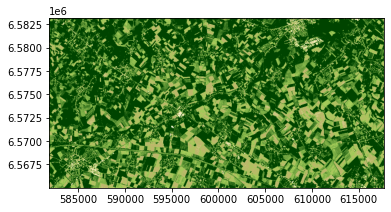

In [257]:
with rasterio.open(ndvi_herstappe) as src:
    herstappe_ndvi = src.read()
    show(herstappe_ndvi, transform=src.transform)

Within the context manager (the `with` statement) we use the `read()` method to load the data itself from the file and assign this to the `herstappe_ndvi` variable. As with the metadata, the data is stored in computer memory and we can work with the data (without affecting the original data on file):

The `show` method is a convenience plotting function provided by the Rasterio Python package. By adding the `transform=src.transform` we get the information of the spatial extent as the x and y axis labels of the plot. We will later learn about other functionalities of Rasterio. 

In [223]:
herstappe_ndvi

array([[[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.74, 0.74, 0.74, ..., 0.  , 0.69, 0.5 ],
        [0.19, 0.74, 0.74, ..., 0.  , 0.74, 0.38],
        [0.06, 0.31, 0.44, ..., 0.  , 0.74, 0.19]],

       [[0.27, 0.27, 0.27, ..., 0.27, 0.27, 0.27],
        [0.27, 0.27, 0.27, ..., 0.27, 0.27, 0.27],
        [0.27, 0.27, 0.27, ..., 0.27, 0.27, 0.27],
        ...,
        [0.72, 0.72, 0.72, ..., 0.27, 0.76, 0.7 ],
        [0.43, 0.72, 0.72, ..., 0.27, 0.72, 0.59],
        [0.33, 0.54, 0.64, ..., 0.27, 0.72, 0.43]],

       [[0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        ...,
        [0.42, 0.42, 0.42, ..., 0.  , 0.38, 0.28],
        [0.11, 0.42, 0.42, ..., 0.  , 0.42, 0.21],
        [0.04, 0.18, 0.25, ..., 0.  , 0.42, 0.11]]], dtype=float32)

The variable `herstappe_ndvi` does not contains any spatial context, but is a 2D array with numeric (float) values. Let's check the data type of this variable:

In [224]:
type(herstappe_ndvi)

numpy.ndarray

When you read raster data using Rasterio you are actually creating a __Numpy array__. A Numpy array does not store spatial information, but is an efficient data type to calculate with arrays in general:

In [80]:
herstappe_ndvi.shape

(3, 635, 1250)

In [226]:
herstappe_ndvi / 10

array([[[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.074, 0.074, 0.074, ..., 0.   , 0.069, 0.05 ],
        [0.019, 0.074, 0.074, ..., 0.   , 0.074, 0.038],
        [0.006, 0.031, 0.044, ..., 0.   , 0.074, 0.019]],

       [[0.027, 0.027, 0.027, ..., 0.027, 0.027, 0.027],
        [0.027, 0.027, 0.027, ..., 0.027, 0.027, 0.027],
        [0.027, 0.027, 0.027, ..., 0.027, 0.027, 0.027],
        ...,
        [0.072, 0.072, 0.072, ..., 0.027, 0.076, 0.07 ],
        [0.043, 0.072, 0.072, ..., 0.027, 0.072, 0.059],
        [0.033, 0.054, 0.064, ..., 0.027, 0.072, 0.043]],

       [[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        ...,
        [0.042, 0.042, 0.042, ..., 0.   , 0.038, 0.028],
        [0.011, 0.042, 0.042, ..., 0.   , 0.0

In [235]:
herstappe_ndvi.shape

(3, 317, 625)

In [241]:
herstappe_ndvi.min(), herstappe_ndvi.max()

(0.0, 1.0)

In [242]:
import matplotlib.pyplot as plt

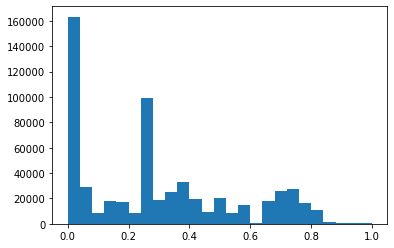

In [251]:
plt.hist(herstappe_ndvi.flatten(), bins=25);

[Numpy](https://numpy.org/) is a fundamental package for scientific computing in the scientific Python ecosystem. Many other packages rely on Numpy as well (Pandas, GeoPandas,...). The bridge in between raster data sets and Numpy enable us to apply the full power of Numpy to spatial data. In the following notebook we will focus on the Numpy package. 

But let's finish this section with some exercises on reading raster data.

<div class="alert alert-success">

**EXERCISE**:

The Geotiff file `./data/gent/raster/2020-09-17_Sentinel_2_L2A_NDVI.tiff` is an NDVI data set downloaded fromt [sentinel-hub](https://www.sentinel-hub.com/). Check the metadata of the file using the `gdalinfo` command and find out:
    
* How many pixels contains the data set?
* How many bands does the data set consist of?
* What is the CRS of the data set?
* What is the resolution of the data set?
    
How is the data set different from the Herstappe data set?
    
<details><summary>Hint</summary>

Any command that works at the command-line can be used in IPython/Jupyter by prefixing it with the `!` character, e.g. `!ls`

</details>

</div>

<div class="alert alert-success">

**EXERCISE**:

Make a __plot of the FIRST band__ of the data stored in the Geotiff file `./data/gent/raster/2020-09-17_Sentinel_2_L2A_NDVI.tiff`.
    
<details><summary>Hints</summary>

- Make sure to use a context manager to access the data files!
- You only need the data of the first band. Check the documentation of the `read` method to see how.
- There are multiple ways of plotting raster data. For this exercise, use the `show` method provide by Rasterio. Make sure the spatial extent information is used as x and y axis labels.

</details>    

</div>

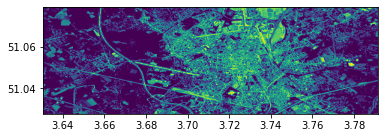

In [260]:
ndvi_gent_file = "./data/gent/raster/2020-09-17_Sentinel_2_L2A_NDVI.tiff"
with rasterio.open(ndvi_gent_file) as gent_gif:
    ndvi_gent = gent_gif.read(1) # only read the first band/layer
    show(ndvi_gent, transform=gent_gif.transform)

<div class="alert alert-success">

**EXERCISE**:

Using Rasterio, read the spatial extent and resolution from two Geotiff example files and assign it to variables:
    
- Geotiff file `./data/gent/raster/2020-09-17_Sentinel_2_L2A_NDVI.tiff`: assign the spatial extent to a variable `gent_extent` and the resolution to `gent_res`
- `./data/herstappe/raster/2018-09-18_Sentinel_2_L2A_NDVI.tiff`: assignthe spatial extent to a variable `herstappe_extent` and the resolution to `herstappe_res` 
    
Do both datasets have the same resolution? 
    
Without doing the calculation, discuss with your neighbours (or break out colleagues) __how__ you would define which data set covers the largest area?
    
<details><summary>Hint</summary>

Make sure to use a context manager to access the data files!

</details>    

</div>

In [345]:
ndvi_gent_file = "./data/gent/raster/2020-09-17_Sentinel_2_L2A_NDVI.tiff"
with rasterio.open(ndvi_gent_file) as src:
    gent_extent = src.bounds
    gent_res = src.res
gent_res, gent_extent

((0.00036002805569027995, 0.00022650647731896144),
 BoundingBox(left=3.6304664611816406, bottom=51.02773828619605, right=3.7913990020751958, top=51.07915525654745))

In [346]:
ndvi_herstappe_file = "./data/herstappe/raster/2018-09-18_Sentinel_2_L2A_NDVI.tiff"
with rasterio.open(ndvi_herstappe) as src:
    herstappe_extent = src.bounds
    herstappe_res = src.res
herstappe_res, herstappe_extent

((57.32777121388223, 57.44833434998037),
 BoundingBox(left=581895.9870779756, bottom=6565004.376100146, right=617725.844086652, top=6583215.49808909))